In [351]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from functools import reduce
from collections import Counter
from nltk.corpus import stopwords as sw
from nltk.util import ngrams

In [309]:
# Grab and process the raw data.
review_names = ['yelp_labelled','amazon_cells_labelled','imdb_labelled']
colnames = ['sentence', 'sentiment']

sentimentlist = []

for review_name in review_names:
    path = "../data/sentiment/" + review_name + ".txt"
    tempdf = pd.read_csv(path,  delimiter= '\t', names=colnames)
    tempname = review_name
    
    # adds location of data to the dataframe
    tempdf['location'] = tempname
    sentimentlist.append(tempdf)

sentiment = pd.concat(sentimentlist)
colnames = ['sentence', 'sentiment']

pos = sentiment['sentence'].loc[sentiment['sentiment'] == 1]
neg = sentiment['sentence'].loc[sentiment['sentiment'] == 0]

sentiment['len'] = sentiment.sentence.apply(lambda value: False if len(value) > 4500 else True)
# sentiment['len'] = sentiment.sentence.apply(len)

In [360]:
# create set of stop words from nltk corpus
def bigram(value):
    tokens = nltk.word_tokenize(value)
    bigrm = list(nltk.bigrams(tokens))
    bigramlist = []
    
    for bigram in bigrm:
        bigramlist.append(' '.join(bigram))
        
    return bigramlist
    
hated = Counter(reduce((lambda x, y: x + y), pos.str.lower().apply(bigram))).most_common(100)
print(hated[30:])

[('very good', 25), ('i love', 24), ('the film', 24), ('the food', 23), ('a good', 23), ('to the', 23), (', it', 23), ('great .', 22), ('well .', 22), ('this film', 22), ('if you', 21), ('the movie', 21), ('is very', 20), ('phone .', 20), ("i 'm", 19), ('i was', 19), ("do n't", 19), ('. 1', 19), ('was a', 18), ('with a', 18), ('for a', 18), ('all the', 18), ('the price', 18), ('i had', 18), ('food was', 17), ('is great', 17), ('i think', 17), ('works great', 17), ('at the', 16), ('to be', 16), (') .', 16), ('i would', 16), ('service .', 15), ('is the', 15), ('i am', 15), ('recommend this', 15), ('service was', 14), ('like a', 14), ('but i', 14), ('in a', 14), ('of this', 14), (', this', 14), ('the sound', 14), ('it has', 14), ('a very', 14), ('film .', 14), ('place .', 13), ('a lot', 13), (', which', 13), ('it !', 13), ('love the', 13), ('in this', 13), ('that i', 13), ('have been', 13), (', a', 13), ('i really', 13), ('of a', 13), ('has a', 13), ('from the', 13), ("'s a", 13), ('to us

In [310]:
stop_words = set(sw.words('english'))
    
goodset = Counter(reduce((lambda x, y: x + y), pos.str.lower().apply(nltk.word_tokenize))).most_common(425)
badset = Counter(reduce((lambda x, y: x + y), neg.str.lower().apply(nltk.word_tokenize))).most_common(425)

In [311]:
goodwords = []
badwords = []

for good in goodset:
    goodwords.append(good[0])
    
for bad in badset:
    badwords.append(bad[0])
    
gooduniquewords = [item for item in goodwords if item not in badwords]
baduniquewords = [item for item in badwords if item not in goodwords]

In [312]:
gooduniquewords = [item for item in gooduniquewords if item not in stop_words]
baduniquewords = [item for item in baduniquewords if item not in stop_words]

In [313]:
for key in baduniquewords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    
    sentiment[str(key)] = sentiment.sentence.str.lower().str.contains(
        ' ' + str(key) + ' ',
        case=True
    )

for key in gooduniquewords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    
    sentiment[str(key)] = sentiment.sentence.str.lower().str.contains(
        ' ' + str(key) + ' ',
        case=True
    )

In [314]:
sentiment['sentiment'] = (sentiment['sentiment'] == 1)
sentiment.sentiment.value_counts()

True     1386
False    1362
Name: sentiment, dtype: int64

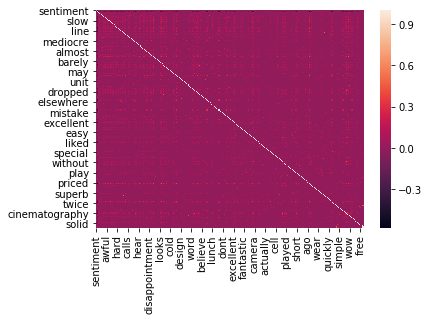

In [315]:
sns.heatmap(sentiment.corr())

In [318]:
data = sentiment[gooduniquewords + baduniquewords + ['len']]
# data = sentiment[gooduniquewords + baduniquewords]
target = sentiment['sentiment']

In [319]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}, {}%".format(
    data.shape[0],
    (target != y_pred).sum(),
    ((target != y_pred).sum()/data.shape[0]*100)
))

Number of mislabeled points out of a total 2748 points : 872, 31.732168850072778%
